# Clasificador de EEG

## Importar librerías

In [1]:
#Importar librerías
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import mlab
from feature_extraction import statistics_feature_extraction as sfe

## Preparación del dataset

In [2]:
#Función de lectura de base de datos
def leer(ruta):    
    import scipy.io
    return scipy.io.loadmat(ruta, struct_as_record = True)

In [3]:
# Cargado el archivo mat
m = leer("BCICIV_1_mat\BCICIV_calib_ds1d.mat")

# Extracción del estudio
EEG = m['cnt'].T
nchannels,nsamples = EEG.shape

# Extracción de los marcadores
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]

# Extracción de la información adicional
sample_rate = m['nfo']['fs'][0][0][0][0]
channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1,cl2 = cl_lab[0],cl_lab[1]
nclases = len(cl_lab)
neventos = len(event_onsets)

# Etiquetas de inicio de clases
labels = np.zeros((1,nsamples),int)
labels[0,event_onsets] = event_codes

In [4]:
# Despliegue de información obtenida
print('Tamaño de EEG:', EEG.shape)
print('Frecuencia de muestreo:', sample_rate)
print('Número de canales:',nchannels)
print('Nombre de canales:',channel_names)
print('Número de eventos:',event_onsets.shape[1])
print('Códigos de eventos:',np.unique(event_codes))
print('Etiquetas de clases:',cl_lab)
print('Número de clases:',nclases)

Tamaño de EEG: (59, 190473)
Frecuencia de muestreo: 100
Número de canales: 59
Nombre de canales: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Número de eventos: 200
Códigos de eventos: [-1  1]
Etiquetas de clases: ['left', 'right']
Número de clases: 2


## Graficar dataset

In [5]:
from matplotlib.collections import LineCollection

def plot_eeg(EEG, chan_ind, vspace=100, color='k', titulo = 'EEG data'):
    '''
    Graficar los datos de EEG, amontonando los canales horizontalmente entre cada uno.

    Parámetros
    -------------------------------------------------------
    EEG : array (canales x muestras)
        El data de EEG
    canales : int (default 10)
        Cantidad de canales a graficar
    vspace : float (default 100)
        Espacio vertical entre los canales
    color : string (default 'k')
        Color de las señales de EEG (default negro)
    -------------------------------------------------------
    '''
    nchans = len(chan_ind)
    bases = vspace * np.arange(nchans)

    # Calcular una línea de tiempo en segundos, sabiendo que la frecuencia de muestreo es de 100 Hz.
    time = np.arange(EEG.T.shape[0]) / sample_rate
    chan_label = []

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Graficar EEG vs tiempo
        plt.plot(time, EEG[ch].T + bases[i], color=color)
        chan_label.append(channel_names[ch])
        # plt.legend()

    # # El eje y son las ubicaciones de los electrodos. Basado en el sistema internacional 10-20.
    plt.gca().yaxis.set_ticks(bases)
    plt.gca().yaxis.set_ticklabels(chan_label)

    # Agregar grid a la gráfica
    plt.grid()
    
    # Etiquetar los ejes
    plt.xlabel('Time (s)')
    plt.ylabel('Channels')
    
    # Agregar un título a la figura
    plt.title(titulo)

    plt.tight_layout()

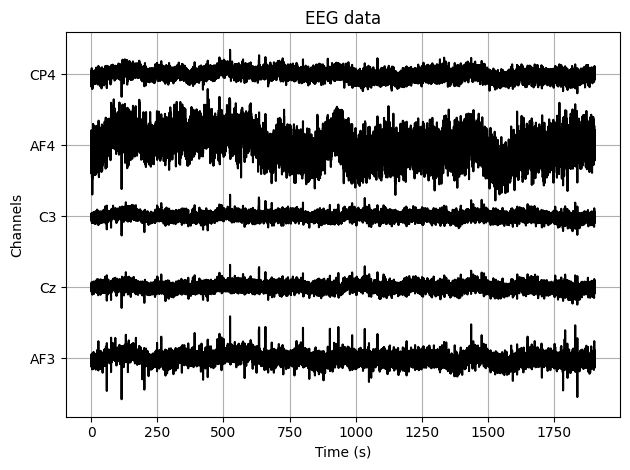

In [6]:
# Graficando el dataset
plot_eeg(EEG,[channel_names.index(ch) for ch in ['AF3','Cz','C3','AF4','CP4']],4000,'k')

## Graficar un solo canal

In [7]:
#Función para graficar una señal de la base de datos
def graficar(x,a,inicio=0,final=-1):
    if final == -1:
        plt.plot(range(inicio,x[a].size-1),x[a][inicio:final])
    else:
        plt.plot(range(inicio,final),x[a][inicio:final])

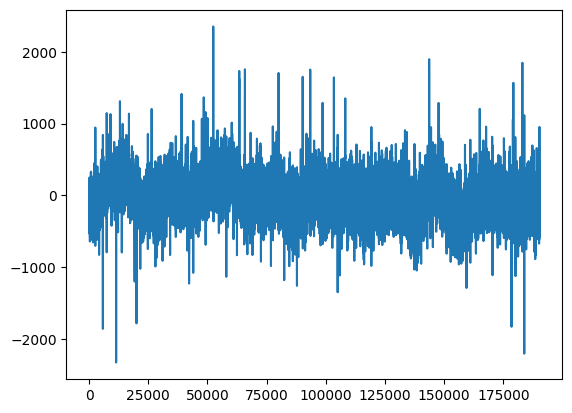

In [8]:
# Probando función
graficar(EEG,0)

## Preparación de los eventos

In [9]:
# Separando los eventos por clases
trials = {}

# Preparación de ventana (en número de muestras) de 0.5 - 2.5 segundos
win = np.arange(int(0.5*sample_rate),int(2.5*sample_rate))
nsamples = len(win)

# Loop entre clases
for cl, code in zip(cl_lab,np.unique(event_codes)):

    # Extraer los encendidos de una clase
    cl_onsets = event_onsets[event_codes==code]

    # Ubicar en memoria los eventos
    trials[cl] = np.zeros((nchannels,nsamples,len(cl_onsets)))

    # Extraer cada evento
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:,win+onset]

# Imprimiendo información de los eventos separados por clase (canales x tiempo x evento)
print('Tamaño de evento [cl1]:',trials[cl1].shape)
print('Tamaño de evento [cl2]:',trials[cl2].shape)

Tamaño de evento [cl1]: (59, 200, 100)
Tamaño de evento [cl2]: (59, 200, 100)


## Procesamiento de la señal

### Filtrado CAR

In [10]:
# Función para eliminar referencia promedio común (CAR) de los electrodos
def eliminar_ruido(x):
    CAR = x.mean(axis=1)
    return (x.transpose() - np.array([CAR])).transpose()

In [11]:
# Probando función
EEG = eliminar_ruido(EEG)

### Cálculo de la Densidad Spectral de Potencia

In [12]:
def psd(trials):
    '''
    Calcula la PSD de cada trial
    
    Parámetros
    -----------------------------
    trials : Array 3D (canales x muestras x trial)

    Retornos
    ----------------------------
    trial_PSD : Array 3D (canales x PSD x trial)
    freqs : Lista de flotantes
        Frecuencia con la que fue computarizado el trial
    '''

    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels,101,ntrials))

    # Iterar sobre trials y canales
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calcular la PSD
            (PSD,freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch,:,trial] = PSD.ravel()
    
    return trials_PSD, freqs

In [13]:
# Aplicando la PSD a las dos clases
psd_1, freqs = psd(trials[cl1])
psd_2, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

In [14]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Grafica la PSD calculada con (psd).

    Parámetros
    -----------------------
    trials_PSD : Array 3D
        El PSD data
    freqs : Lista de flotantes
        Las frecuencias a las que se definió el PSD
    chan_ind : Lista de enteros
        Indica los canales a graficar
    chan_lab : Lista de cadenas
        (opcional) Lista de los nombres de los canales
    maxy : Flotante
        (opcional) : Límite del eje y
    '''

    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Máximo 3 gráficas por renglón
    nrows = int(np.ceil(nchans/3))
    ncols = min(3, nchans)

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Cuál subplot graficar
        plt.subplot(nrows,ncols,i+1)

        # Graficar el PSD para cada clase
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
        
        # Estilizar la gráfica
        plt.xlim(1,30)

        if maxy!= None:
            plt.ylim(0,maxy)
        
        plt.grid()
        plt.xlabel('Frecuencia (Hz)')

        if chan_lab is None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])
        
        plt.legend()
    
    plt.tight_layout()

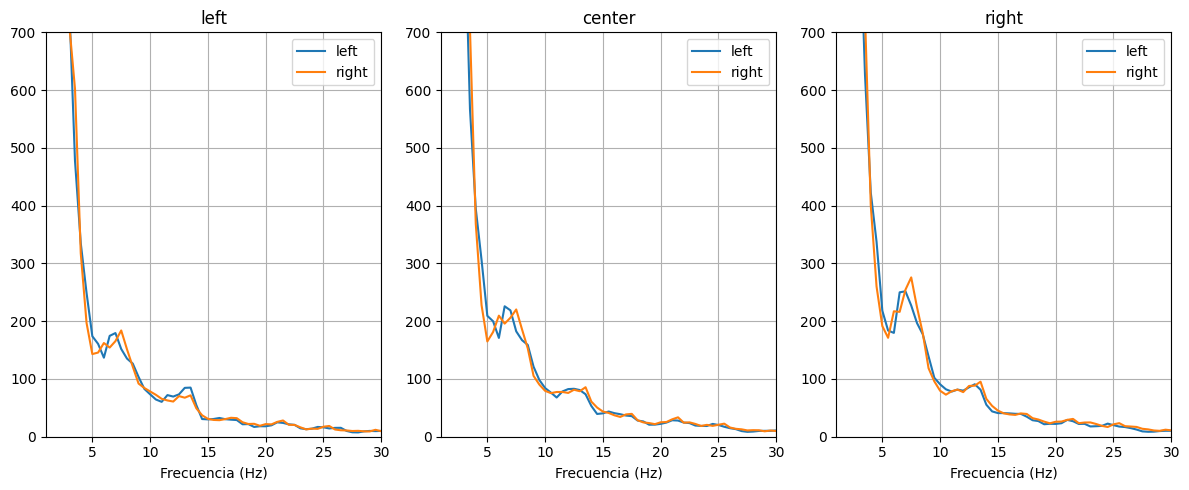

In [15]:
# Probando función plot_psd()

# 1. C3: Central, left
# 2. Cz: Central, central
# 3. C4: Central, right

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=700
)

### Filtrado de la señal

In [16]:
import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Diseña y aplica un filtro pasa banda a la señal

    Parámetros
    -----------------------
    trials : Array 3D (canales x muestras x trial)
        La señal de EEG
    lo : flotante
        Frecuencia de corte uno (Hz)
    hi : flotante
        Frecuencia de corte dos (Hz)
    sample_rate : flotante
        Frecuencia de muestreo (Hz)

    Retorno
    -----------------------
    trials_filt : Array 3D (canales x muestras x trial)
        La señal filtrada        
    '''

    a,b = scipy.signal.iirfilter(6,[lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Aplicando el filtro a cada trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels,nsamples,ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a,b,trials[:,:,i],axis=1)
    return trials_filt

In [17]:
# Probando la función
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),cl2: bandpass(trials[cl2], 8, 15, sample_rate),}

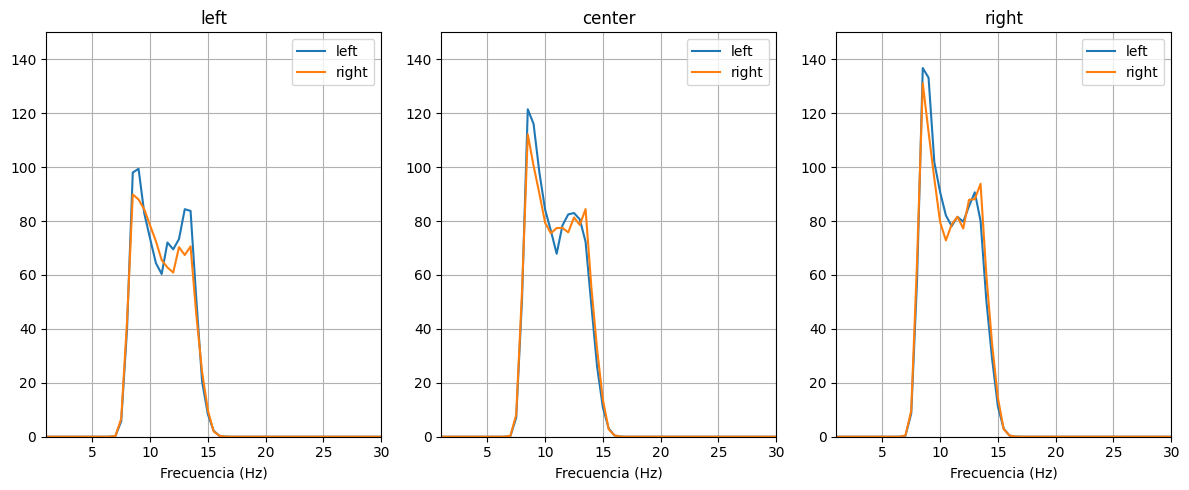

In [18]:
# Aplicando la PSD a las señales filtradas
psd_1, freqs = psd(trials_filt[cl1])
psd_2, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=150
)

### Calcular el logaritmo de las pruebas

In [19]:
# Función para calcular el valor logaritmo de cada canal
def logvar(trials):
    '''
    Calcular el valor logaritmo de cada canal

    Parámetros
    ---------------------------
    trials: Array 3D (canales x muestras x trials)
        La señal de EEG.
    
    Retorno
    ---------------------------
    logvar : Array 2D (canales x trials)
        Para cada canal calcula su valor logarítmico
    '''

    return np.log(np.var(trials, axis=1))

In [20]:
# Probando la función
trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}

### Función para visualizar el logaritmo de cada canal

In [21]:
def plot_logvar(trials):
    '''
    Graficar el valor logaritmo de cada canal

    Parámetros
    -------------------
    trials : Diccionario que contiene los trials (log-vars x trials) para 2 clases.
    '''

    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var de cada canal/componente')
    plt.xlabel('Canales/componentes')
    plt.ylabel('Log-var')
    plt.legend(cl_lab)

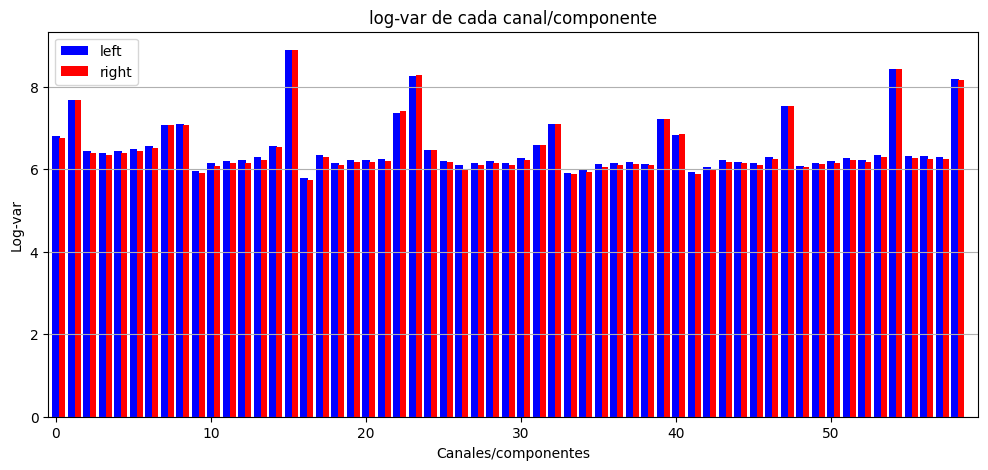

In [22]:
# Probando la función
plot_logvar(trials_logvar)

- Vemos que la mayoría de los canales muestran una pequeña diferencia en el log-var de la señal entre las dos clases.
- El siguiente paso es pasar de 59 canales a sólo unas pocas mezclas de canales.
- El algoritmo CSP calcula mezclas de canales que están diseñadas para maximizar la diferencia de variación entre dos clases.
- Estas mezclas se denominan filtros espaciales.

## Algoritmo Common Special Filtering (CSP)

In [23]:
from scipy import linalg
def cov(trials):
    '''Calcula la covarianza de cada prueba y entrega el promedio'''
    ntrials = trials.shape[2]
    covs = [trials[:,:,i].dot(trials[:,:,i].T) /nsamples for i in range(ntrials)]
    return np.mean(covs, axis=0)

def whitening(sigma):
    '''Calcula el whitering de una matrix de covarianza sigma'''
    U, l, _ = linalg.svd(sigma)
    return U.dot(np.diag(l ** -0.5))

def csp(trials_1, trials_2):
    '''
    Calcula la transformada CSP matriz W.

    Argumentos:
    ------------------
        trials_r : Array (canales x muestras x trials) movimientos derecha
        trials_f : Array (canales x muestras x trials) movimientos izquierda

    Retornos:
    -----------------
        Matriz mezclada W
    '''
    cov_1 = cov(trials_1)
    cov_2 = cov(trials_2)
    P = whitening(cov_1 + cov_2)
    B, _, _ = linalg.svd(P.T.dot(cov_2).dot(P))
    W = P.dot(B)
    return W

def apply_mix(W,trials):
    '''Aplica la matriz mezclada a cada trial (multiplica W con la matriz de señal EEG'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples,ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [24]:
# Probando la función
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),cl2: apply_mix(W, trials_filt[cl2])}

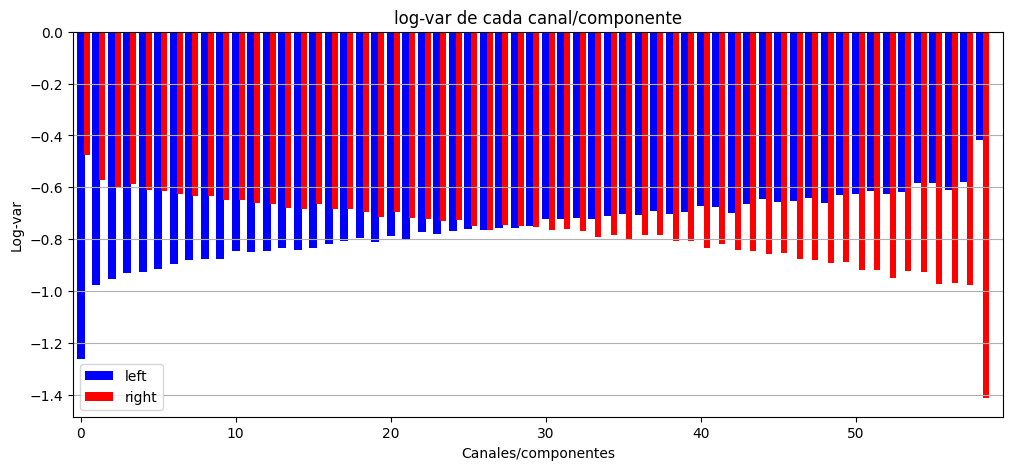

In [25]:
# Graficando log-var una vez aplicado el algoritmo CSP
trials_logvar = {cl1: logvar(trials_csp[cl1]),cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

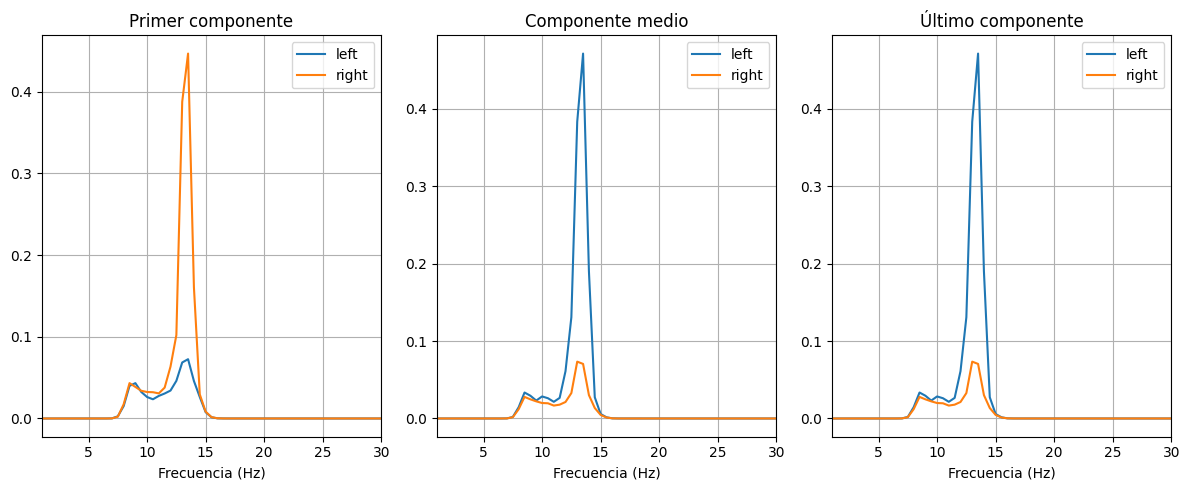

In [26]:
# Graficando PSD del CSP
psd_1, freqs = psd(trials_csp[cl1])
psd_2, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(trials_PSD, freqs, [0,58,-1], chan_lab = ['Primer componente', 'Componente medio', 'Último componente'])

In [27]:
def plot_scatter(one, two):
    plt.figure()
    plt.scatter(one[0,:], one[-1,:], color='b')
    plt.scatter(two[0,:], two[-1,:], color='r')
    plt.xlabel('Último componente')
    plt.ylabel('Primer componente')
    plt.legend(cl_lab)

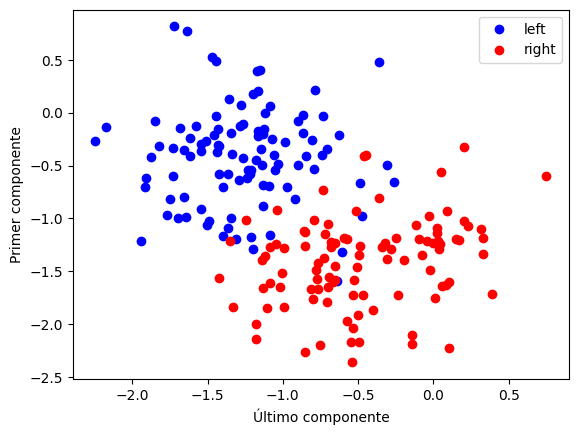

In [28]:
# Probando la función
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

## Clasificación

### Extracción de características

In [29]:
vec_car = sfe(EEG[0])
arr_vec_car = np.array(vec_car)

In [30]:
#Impirmir vector resultante
print('Vector de características es:',arr_vec_car)
print('La cantidad de características extraídas son:',len(arr_vec_car))

Vector de características es: [ 1.22238135e-14  1.22238135e-14  2.37070003e+03  2.37070003e+03
 -2.30529997e+03  2.30529997e+03  6.54000620e+01  4.67600000e+03
  7.06469700e+06  6.45046826e+04  3.48912207e+03 -4.24504212e+04
  3.80655499e+07  2.53977721e+02  6.45046826e+04  6.73548936e-02
  4.07702389e+00  3.67391190e-05 -1.29996902e+00]
La cantidad de características extraídas son: 19
